<a href="https://colab.research.google.com/github/Jav-DL/fastai-v3/blob/master/Lesson_3_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

# Getting the data from Kaggle

In [0]:
! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/.kaggle"

In [0]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"YOUR_USERNAME","key":"YOUR_KEY"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory


In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!kaggle datasets list

In [0]:
#Creating folder
!mkdir /content/planet
path ='/content/planet'


mkdir: cannot create directory ‘/content/planet’: File exists


In [0]:
#Download and unzip data
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 593M/600M [00:09<00:00, 38.9MB/s]
100% 600M/600M [00:09<00:00, 67.2MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 76.0MB/s]


In [0]:
!pip install pyunpack
!pip install patool

In [0]:
from pyunpack import Archive
Archive('/content/planet/train-jpg.tar.7z').extractall('/content/planet/')

In [0]:
from pyunpack import Archive
Archive('/content/planet/train-jpg.tar').extractall('/content/planet/')

# Reading the data

In [0]:
import pandas as pd
df = pd.read_csv('/content/planet/train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


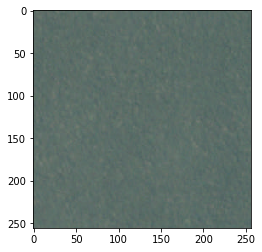

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/planet/train-jpg/'+df.iloc[0,0]+'.jpg')
imgplot = plt.imshow(img)
plt.show()


In [0]:
os.listdir('/content/planet/train-jpg')
# dir(os)

In [0]:
dir(df)
# print(df.shape)
# print(df.size)
# print(df.idxmin,df.idxmax)
# df.__getitem__('image_name')[2]

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
data = (ImageList.from_csv('/content/planet/', 'train_v2.csv', folder='train-jpg', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim=' ')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

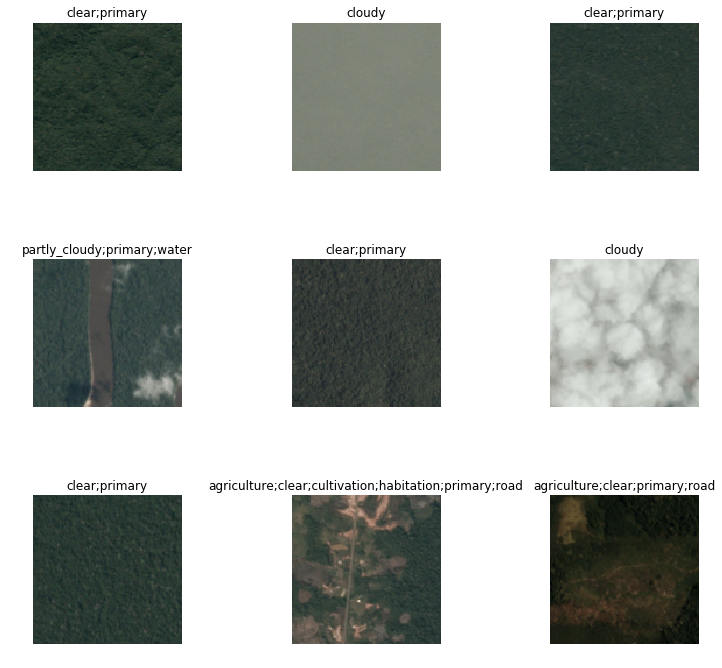

In [0]:
data.show_batch(rows=3, figsize=(10,10))

In [0]:
data.classes
data.c

17

In [0]:
print(data.classes)
len(data.classes),data.c
data.c??

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


# Loading neural network and training using data

In [0]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 36507791.15it/s]


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


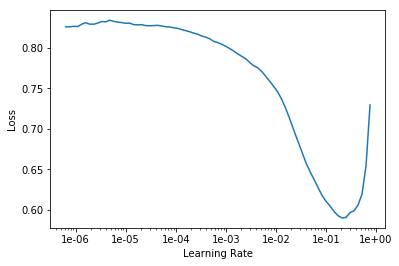

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4,slice(0.02))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.125667,0.109601,0.949192,0.904119,03:51
1,0.113437,0.097008,0.948356,0.914599,03:49
2,0.103213,0.090900,0.953457,0.921252,03:49
3,0.090779,0.088205,0.954758,0.923024,03:44


In [0]:
learn.save('stage-1-rn50') #Stage-1 is the name

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


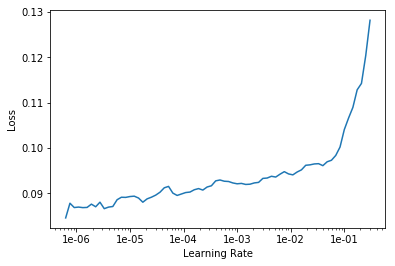

In [0]:
learn.recorder.plot()

In [0]:
lr =0.9e-3

In [0]:
learn.fit_one_cycle(5, slice(lr,lr/5 ))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.091720,0.087744,0.955717,0.924390,03:47
1,0.091304,0.087705,0.955295,0.923522,03:50
2,0.093112,0.088221,0.956146,0.925351,03:48
3,0.088052,0.086713,0.956894,0.924304,03:52
4,0.089056,0.089447,0.956059,0.924736,03:52


In [0]:
#It is on the verge of overfitting. loss function doesn't decrease anymore
learn.save('stage-2-rn50') #Stage-2 is the name

# Fine-tuning
1. Unfreeze
2. Find lr and plot
3. Learn again

Note: if I got a number of errors recorded, I can run again with the small data of those errors.

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


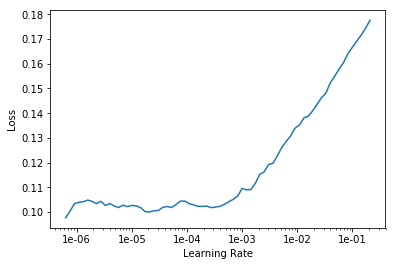

In [0]:
learn.recorder.plot()

# Improving the model even further
1. Freeze the model
2. Increase picture size. Initially trained with size 128. Do size 256 - it is considered a new data set.
3. Do transfer learning.

In [0]:
learn.freeze()

In [0]:
data_256 = (ImageList.from_csv('/content/planet/', 'train_v2.csv', folder='train-jpg', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim=' ')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=256)
        #Data augmentation? -> use tfms with a size of 128
        .databunch(bs=40))                          
        #Finally -> use the defaults for conversion to databunch

In [0]:
learn.data = data_256
data.train_ds[0][0].shape

torch.Size([3, 128, 128])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


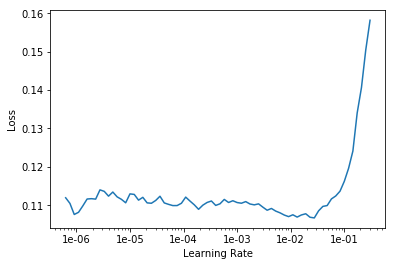

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098320,0.089661,0.957323,0.922541,11:23
1,0.099797,0.090009,0.959910,0.923121,11:19


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.092475,0.088055,0.955267,0.922595,15:28
1,0.097415,0.112864,0.954772,0.920578,15:24
2,0.088959,0.113897,0.958609,0.924835,15:24
3,0.084572,0.109789,0.958108,0.927602,15:29
4,0.081056,0.091661,0.959946,0.929398,15:28


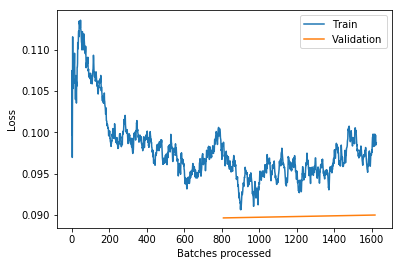

In [0]:
learn.recorder.plot_losses()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

In [0]:
interp.plot_confusion_matrix

<bound method ClassificationInterpretation.plot_confusion_matrix of <fastai.train.ClassificationInterpretation object at 0x7f0812cd6208>>

IndexError: ignored

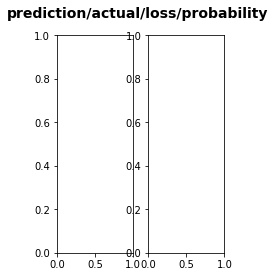

In [0]:
interp.plot_top_losses(2, figsize=(3,4))

In [0]:
learn = learn.load("stage-2-rn50")

In [0]:
learn = cnn_learner(data, models.resnet50).load('stage-2-rn50')

In [0]:
#Exporting before loading for inference
learn.export()

In [0]:
data_test = (ImageList.from_csv('/content/planet/', 'train_v2.csv', folder='train-jpg', suffix='.jpg')

In [0]:
learn = load_learner(planet)

NameError: ignored